In [630]:
# Librerías
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from time import sleep
from IPython.display import clear_output

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV

### Datos

In [10]:
# Datos
data = pd.read_csv('bloodpress.txt', delimiter="\t", index_col=0) # assuming your data is tab-separated
data.head()

,BP,Age,Weight,BSA,Dur,Pulse,Stress
Pt,,,,,,,
1,105,47,85.4,1.75,5.1,63,33
2,115,49,94.2,2.10,3.8,70,14
3,116,49,95.3,1.98,8.2,72,10
4,117,50,94.7,2.01,5.8,73,99
5,112,51,89.4,1.89,7.0,72,95


In [11]:
# Estructura
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 1 to 20
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BP      20 non-null     int64  
 1   Age     20 non-null     int64  
 2   Weight  20 non-null     float64
 3   BSA     20 non-null     float64
 4   Dur     20 non-null     float64
 5   Pulse   20 non-null     int64  
 6   Stress  20 non-null     int64  
dtypes: float64(3), int64(4)
memory usage: 1.2 KB


### Ejemplo univariado

In [13]:
target = data.columns[0]
feature = data.columns[2]

In [14]:
# Target y atributos
X = data[feature]
y = data[target]

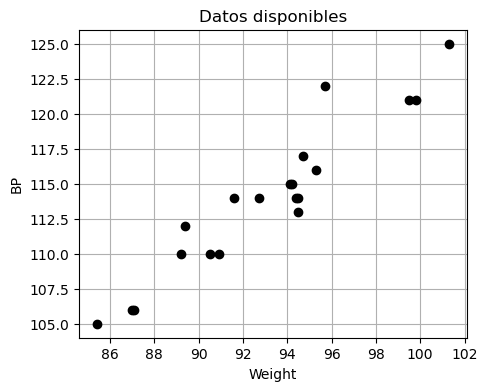

In [15]:
# Gráfica de datos de entrenamiento y recta de regresión
plt.figure(figsize=(5,4))
plt.scatter(X, y, color='black', label='Datos', zorder=3)
plt.xlabel(feature)
plt.ylabel(target)
plt.title('Datos disponibles')
plt.grid(True)
plt.show()

In [21]:
# Correlación
X.corr(y).round(decimals=2)

0.95

#### Explorando la MSE (a mano)

In [326]:
# Inicializamos registros para análisis posterior
b_list = []
w_list = []
mse_list = []

In [327]:
# Inicializamos el bias b y el peso w
b = 0
w = 0

In [328]:
# Definimos un tamaño para el paso
step = 0.1

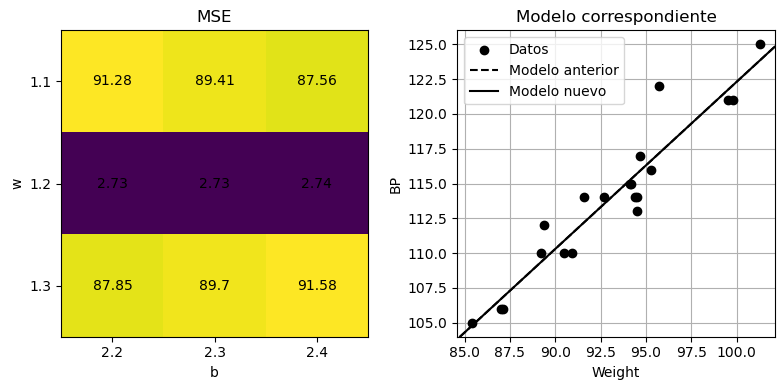

In [329]:
Iter = 30

for _ in range(Iter):
    clear_output(wait=True)

    # PASO 1

    # Registramos b y w
    b_list.append(b)
    w_list.append(w)

    # Definimos una grilla de w's y b's vecinos al valor actual
    b_vals = np.linspace(b-step, b+step, 3)
    w_vals = np.linspace(w-step, w+step, 3)
    B, W = np.meshgrid(b_vals, w_vals)

    # PASO 2

    # Calculamos la MSE para cada par b, w en la grilla
    MSE = np.zeros(W.shape)
    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            bb, ww = B[i, j], W[i, j]
            y_pred = bb + ww*X
            mse = np.mean((y - y_pred) ** 2)
            MSE[i, j] = mse

    # Registramos mse
    mse_list.append(MSE[1,1])

    # PASO 3

    # Buscamos el mejor par b_new y w_new
    i = np.where(MSE==np.min(MSE))[0][0]
    j = np.where(MSE==np.min(MSE))[1][0]
    b_new = b_vals[j]
    w_new = w_vals[i]
    
    fig, axes = plt.subplots(1, 2, figsize=(8,4))

    # Visualizamos la MSE en los vecinos a b, w
    axes[0].imshow(MSE, interpolation=None, cmap='viridis')
    axes[0].set_title('MSE')
    axes[0].set_xticks([0,1,2])
    axes[0].set_yticks([0,1,2])
    axes[0].set_xticklabels(b_vals.round(2))
    axes[0].set_yticklabels(w_vals.round(2))
    axes[0].set_xlabel('b')
    axes[0].set_ylabel('w')

    for (j,i), label in np.ndenumerate(MSE.round(2)):
        axes[0].text(i, j, label, ha='center', va='center')

    # Gráfica de datos de entrenamiento y recta de regresión
    axes[1].scatter(X, y, color='black', label='Datos', zorder=3)
    xlim = axes[1].get_xlim()
    ylim = axes[1].get_ylim()
    axes[1].axline((0, b), slope=w, color='black', linestyle='dashed', label='Modelo anterior')
    axes[1].axline((0, b_new), slope=w_new, color='black', label='Modelo nuevo')
    axes[1].set_xlabel(feature)
    axes[1].set_ylabel(target)
    axes[1].set_title('Modelo correspondiente')
    axes[1].set_xlim(xlim)
    axes[1].set_ylim(ylim)
    axes[1].grid(True)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    # PASO 4

    # Actualizamos b y w y volvemos al PASO 1
    b = b_new
    w = w_new

    sleep(5)


In [330]:
# RESULTADO
print(f'b final: {b}')
print(f'w final: {w}')

b final: 2.3000000000000007
w final: 1.2


#### Comparación con cálculo exacto

In [324]:
# CALCULO EXACTO
w_hat = X.corr(y) * (y.std()/X.std())
b_hat = y.mean() - w_hat * X.mean()

print(f'b_hat: {b_hat}')
print(f'w_hat: {w_hat}')

b_hat: 2.205305325869233
w_hat: 1.200931299539486


In [336]:
# Definimos grilla para ver resultados
b_vals = np.linspace(b_hat-3, b_hat + 3, 100)
w_vals = np.linspace(0, w_hat + 0.5, 100)
B, W = np.meshgrid(b_vals, w_vals)

In [337]:
# Calculamos la MSE para cada par b, w en la grilla
MSE = np.zeros(W.shape)
for i in range(W.shape[0]):
    for j in range(W.shape[1]):
        bb, ww = B[i, j], W[i, j]
        y_pred = bb + ww*X
        mse = np.mean((y - y_pred) ** 2)
        MSE[i, j] = mse

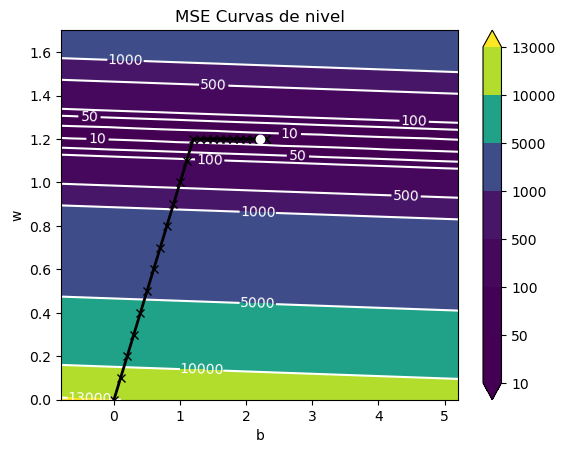

In [362]:
# Plotting
plt.figure()

# Especificamos valores de contornos
levels = [10, 50, 100, 500, 1000, 5000, 10000, 13000]

# Contornos rellenos
cp = plt.contourf(B,
                  W,
                  MSE,
                  levels=levels,
                  cmap='viridis',
                  extend='both'
                  )

# Lineas de contorno
contour = plt.contour(B,
                      W,
                      MSE,
                      levels=levels,
                      colors='white'
                      )

# Valores de las lineas
plt.clabel(contour, inline=True, fontsize=10)

plt.colorbar(cp)
plt.title('MSE Curvas de nivel')
plt.xlabel('b')
plt.ylabel('w')

plt.plot(b_list,w_list, linewidth=2, marker='x', color='black')

# Optimo
plt.plot(b_hat, w_hat, color='white', marker='o')

plt.show()

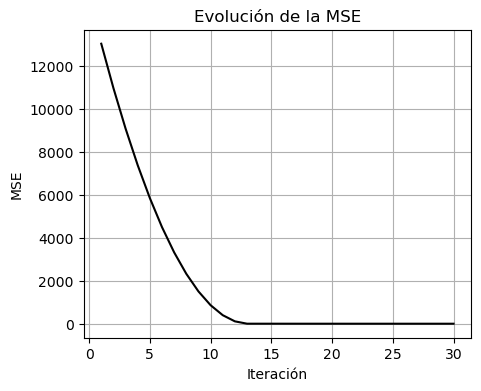

In [346]:
# Gráfica de MSE en función de la iteración
plt.figure(figsize=(5,4))
plt.plot(range(1,Iter+1), mse_list, color='black', label='Datos', zorder=3)
plt.xlabel('Iteración')
plt.ylabel('MSE')
plt.title('Evolución de la MSE')
plt.grid(True)
plt.show()

#### Usando *sklearn*

In [347]:
# Modelo lineal de sklearn
model = LinearRegression()

In [349]:
# Entrenamos (buscamos el mínimo de la MSE)
model.fit(X.values.reshape(-1,1), y)

LinearRegression()

In [357]:
# Print the model coefficients
print("Bias:", model.intercept_)
print("Weight:", model.coef_)

Bias: 2.2053053258691904
Weight: [1.2009313]


In [358]:
# Prededir BP
y_pred = model.predict(X.values.reshape(-1,1))

In [383]:
# Calculate and print R2 and MSE
print("Correlación entre X e y:", X.corr(y).round(3))
print("Correlación entre y e y_pred:", np.corrcoef(y,y_pred).round(3)[0,1])
print("Correlación entre X e y al cuadrado:", np.round(X.corr(y)**2,decimals=3))
print("R2 (coeficiente de determinación):", r2_score(y, y_pred).round(3))
print("Variabilidad explicada:", np.round(np.var(y_pred)/np.var(y), decimals=3))
print("Mean Squared Error (MSE):", np.round(mean_squared_error(y, y_pred),decimals=3))
print("Fórmula MSE vs correlación:", np.round(np.var(y)*(1-X.corr(y)**2),decimals=3))

Correlación entre X e y: 0.95
Correlación entre y e y_pred: 0.95
Correlación entre X e y al cuadrado: 0.903
R2 (coeficiente de determinación): 0.903
Variabilidad explicada: 0.903
Mean Squared Error (MSE): 2.726
Fórmula MSE vs correlación: 2.726


### Ejemplo multivariado

In [395]:
# Target y atributos
X = data[['Age', 'Weight']]
y = data['BP']

In [396]:
# Ahora tenemos 2 atributos
X.head()

,Age,Weight
Pt,,
1,47,85.4
2,49,94.2
3,49,95.3
4,50,94.7
5,51,89.4


In [401]:
# Correlación entre atributos
correlation_matrix = X.corr()
print(correlation_matrix)

             Age    Weight
Age     1.000000  0.407349
Weight  0.407349  1.000000


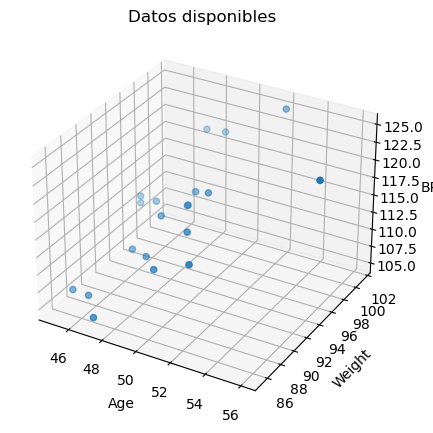

In [422]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection='3d')

ax.scatter(X['Age'], X['Weight'], y)

ax.set_xlabel('Age') 
ax.set_ylabel('Weight') 
ax.set_zlabel('BP')

ax.set_title('Datos disponibles')

plt.show()

In [573]:
# Modelo lineal de sklearn
model = LinearRegression()

In [574]:
# Minimizamos MSE
model.fit(X, y)

LinearRegression()

In [575]:
# Weight & Bias
print("Bias:", model.intercept_)
coeff_df = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print(coeff_df)

Bias: -16.57936937763961
        Coefficient
Age        0.708251
Weight     1.032961


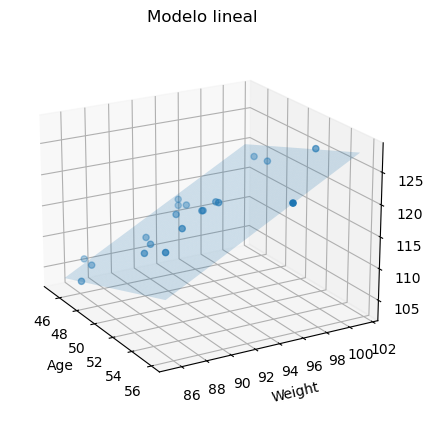

In [576]:
b = model.intercept_
w_Age = model.coef_[0]
w_Weight = model.coef_[1]

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection='3d')

ax.scatter(X['Age'], X['Weight'], y)

range_Age = np.linspace(X['Age'].min(), X['Age'].max(), 100)
range_Weight = np.linspace(X['Weight'].min(), X['Weight'].max(), 100)
xx, yy = np.meshgrid(range_Age, range_Weight)

z = b + w_Age * xx + w_Weight * yy 

ax.plot_surface(xx, yy, z, alpha=0.2)

ax.set_xlabel('Age') 
ax.set_ylabel('Weight') 
ax.set_zlabel('BP')

ax.set_title('Modelo lineal')

ax.view_init(20, -30)

plt.show()

In [577]:
# Predecimos BP
y_pred = model.predict(X)

In [578]:
# Calculamos R2 y MSE
print("R2 (coefficient of determination):", r2_score(y, y_pred))
print("Mean Squared Error (MSE):", mean_squared_error(y, y_pred))

R2 (coefficient of determination): 0.991385845204099
Mean Squared Error (MSE): 0.24119633428522938


In [579]:
# Promedios
y_mean = np.mean(y)
mean_Age = X.mean()['Age']
mean_Weight = X.mean()['Weight']

In [580]:
# Grilla para w1 y w2
w_Age_vals = np.linspace(-1, 2, 100)
w_Weight_vals = np.linspace(-1, 2, 100)
W_Age, W_Weight = np.meshgrid(w_Age_vals, w_Weight_vals)

In [581]:
# MSE para todos los pares w_Age y w_Weight
MSE = np.zeros((W_Weight.shape[0], W_Age.shape[1]))
for i in range(W_Weight.shape[0]):
    for j in range(W_Age.shape[1]):
        w1, w2 = W_Age[i, j], W_Weight[i, j]
        w0 = y_mean - w1*mean_Age - w2*mean_Weight
        y_pred = w0 + w1*X['Age'] + w2*X['Weight']
        mse = np.mean((y.values - y_pred) ** 2)
        MSE[i, j] = mse

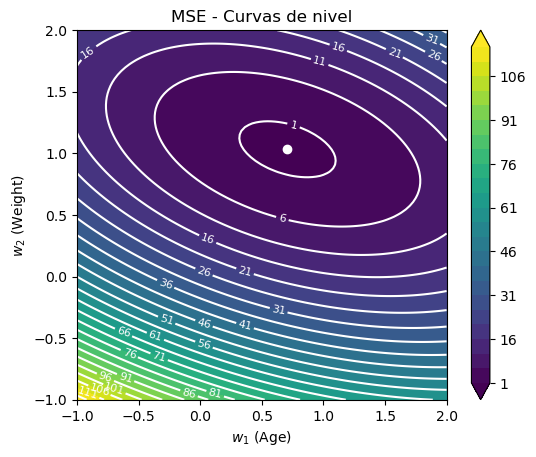

In [582]:
# Plotting
plt.figure()

# Niveles
levels = range(1,120,5)

# Contornos
cp = plt.contourf(W_Age,
                  W_Weight,
                  MSE,
                  levels = levels,
                  cmap='viridis',
                  extend='both')

contour = plt.contour(W_Age,
                      W_Weight,
                      MSE,
                      levels=levels,
                      colors='white')

# Etiquetas
plt.clabel(contour, inline=True, fontsize=8)

# Optimo
plt.plot(model.coef_[0], model.coef_[1], color='white', marker='o')

plt.colorbar(cp)
plt.title(r'MSE - Curvas de nivel')
plt.xlabel(r'$w_1$ (Age)')
plt.ylabel(r'$w_2$ (Weight)')

# Preserve the aspect ratio
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

### Ejemplo estandarizar

In [583]:
# Estandarizamos los atributos
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [584]:
# Trnasformamos en dataframe
X_std = pd.DataFrame(X_std, columns=['Age', 'Weight'])
X_std.head()

,Age,Weight
0,-0.656488,-1.837008
1,0.164122,0.265160
2,0.164122,0.527931
3,0.574427,0.384601
4,0.984732,-0.881477


In [596]:
# Determinante de matriz de correlaciones
np.linalg.det(X_std.cov())

0.9241734949177572

In [585]:
# Modelo lineal de sklearn
model_std = LinearRegression()

In [586]:
# Minimizamos la MSE
model_std.fit(X_std, y)

LinearRegression()

In [587]:
# Predecimos BP
y_pred = model_std.predict(X_std)

In [588]:
# Calculamos R2 y MSE
print("R2 (coefficient of determination):", r2_score(y, y_pred))
print("Mean Squared Error (MSE):", mean_squared_error(y, y_pred))

R2 (coefficient of determination): 0.9913858452040989
Mean Squared Error (MSE): 0.24119633428523185


In [589]:
# Coeficientes
print("Bias:", model_std.intercept_)
coeff_df = pd.DataFrame(model_std.coef_, X.columns, columns=['Coefficient'])
print(coeff_df)

Bias: 114.0
        Coefficient
Age        1.726159
Weight     4.324136


In [590]:
# Promedio
y_mean = np.mean(y)
print(y_mean)

114.0


In [591]:
# Grilla
w_Age_std_vals = np.linspace(0, 3, 100)
w_Weight_std_vals = np.linspace(2.5, 5.5, 100)
W_Age_std, W_Weight_std = np.meshgrid(w_Age_std_vals, w_Weight_std_vals)

In [592]:
# MSE
MSE_std = np.zeros((W_Weight_std.shape[0],W_Age_std.shape[1]))
for i in range(W_Weight_std.shape[0]):
    for j in range(W_Age_std.shape[1]):
        w1, w2 = W_Age_std[i, j], W_Weight_std[i, j]
        w0 = y_mean
        y_pred = w0 + w1*X_std['Age'] + w2*X_std['Weight']
        mse_std = np.mean((y.values - y_pred) ** 2)
        MSE_std[i, j] = mse_std

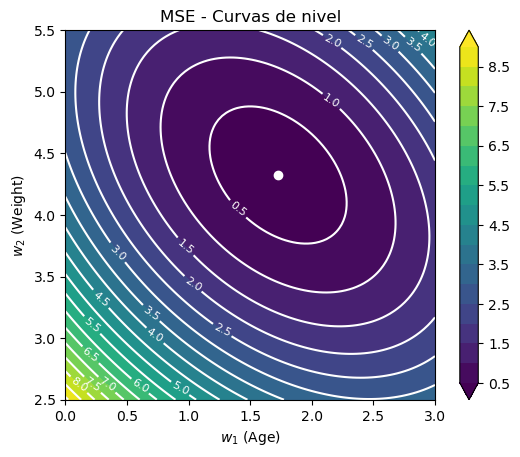

In [593]:
# Plotting
plt.figure()

# Contornos
cp = plt.contourf(W_Age_std,
                  W_Weight_std,
                  MSE_std,
                  levels = 20,
                  cmap='viridis',
                  extend='both')

contour = plt.contour(W_Age_std,
                      W_Weight_std,
                      MSE_std,
                      levels=20,
                      colors='white')

# Etiquetas
plt.clabel(contour, inline=True, fontsize=8)

# Optimo
plt.plot(model_std.coef_[0], model_std.coef_[1], color='white', marker='o')

plt.colorbar(cp)
plt.title(r'MSE - Curvas de nivel')
plt.xlabel(r'$w_1$ (Age)')
plt.ylabel(r'$w_2$ (Weight)')

# Preserve the aspect ratio
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

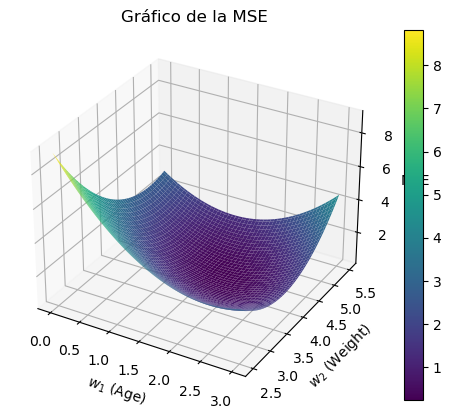

In [597]:
# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 3D surface plot
surf = ax.plot_surface(W_Age_std, W_Weight_std, MSE_std, cmap='viridis')

# Labels and title
ax.set_xlabel(r'$w_1$ (Age)')
ax.set_ylabel(r'$w_2$ (Weight)')
ax.set_zlabel('MSE')
ax.set_title('Gráfico de la MSE')
fig.colorbar(surf)

plt.show()

### Ejemplo Ridge

In [648]:
# Definimos rango de alphas
alphas = np.logspace(-6,6,100)

In [649]:
# Cross-Validation Error vs. Ridge Parameter

# Definimos modelos
ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)

# Ajustamos
ridge_cv.fit(X_std, y)

# Calculamos error en CV
cv_mse = np.mean(ridge_cv.cv_values_, axis=0)

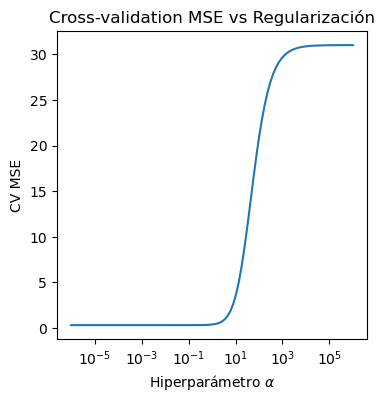

In [650]:
# Graficamos resultados
plt.figure(figsize=(4,4))
plt.plot(alphas, cv_mse)
plt.xscale('log')
plt.xlabel(r'Hiperparámetro $\alpha$')
plt.ylabel('CV MSE')
plt.title('Cross-validation MSE vs Regularización')
plt.show()

In [618]:
# Mejor alpha
best_alpha = ridge_cv.alpha_

# Coeficientes
best_coefs = ridge_cv.coef_

print(f"Mejor alpha: {best_alpha}")
print(f"Coeficientes: {best_coefs}")

Mejor alpha: 0.0032745491628777285
Coeficientes: [1.72616549 4.32342537]


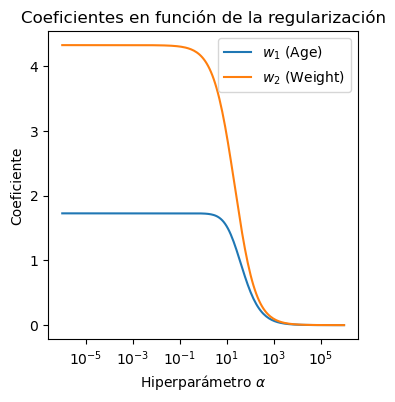

In [646]:
# Coeficientes vs. Parámetro Ridge
coef_list_ridge = []

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_std, y)
    coef_list_ridge.append(ridge.coef_)

coefs_ridge = np.array(coef_list_ridge)

plt.figure(figsize=(4,4))
plt.plot(alphas, coefs_ridge[:, 0], label=r'$w_1$ (Age)')
plt.plot(alphas, coefs_ridge[:, 1], label=r'$w_2$ (Weight)')
plt.xscale('log')
plt.xlabel(r'Hiperparámetro $\alpha$')
plt.ylabel(r'Coeficiente')
plt.legend()
plt.title('Coeficientes en función de la regularización')
plt.show()

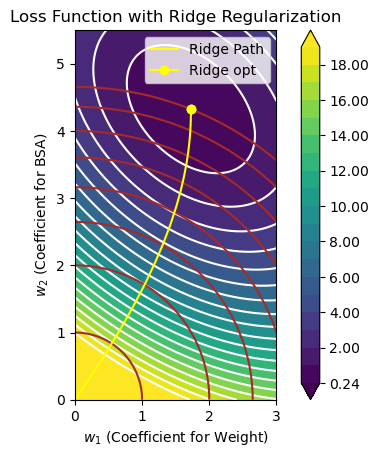

In [629]:
# Curvas de nivel - Geometría de Ridge

# Grilla
w_Age_std_vals = np.linspace(0, 3, 100)
w_Weight_std_vals = np.linspace(0, 5.5, 100)
W_Age_std, W_Weight_std = np.meshgrid(w_Age_std_vals, w_Weight_std_vals)

# MSE
MSE_std = np.zeros((W_Weight_std.shape[0],W_Age_std.shape[1]))
for i in range(W_Weight_std.shape[0]):
    for j in range(W_Age_std.shape[1]):
        w1, w2 = W_Age_std[i, j], W_Weight_std[i, j]
        w0 = y_mean
        y_pred = w0 + w1*X_std['Age'] + w2*X_std['Weight']
        mse_std = np.mean((y.values - y_pred) ** 2)
        MSE_std[i, j] = mse_std

w1 = best_coefs[0]
w2 = best_coefs[1]

# Óptimo con ridge
w0 = y_mean
y_pred = w0 + w1*X_std['Age'] + w2*X_std['Weight']
mse_level = np.mean((y.values - y_pred) ** 2)
levels = [mse_level]
levels.extend(range(1,20))
ridge_levels = [best_alpha * r for r in range(1,21,3)]
ridge_levels.append(best_alpha*np.sum(np.array([w1, w2]) ** 2))

ridge_norm = np.zeros_like(MSE_std)
for i in range(W_Weight_std.shape[0]):
    for j in range(W_Age_std.shape[1]):
        w1, w2 = W_Weight_std[i, j], W_Age_std[i, j]
        ridge_norm[i, j] = best_alpha*np.sum(np.array([w1, w2]) ** 2)

plt.figure()
cp = plt.contourf(W_Age_std, W_Weight_std, MSE_std, levels=levels, cmap='viridis', alpha=1, extend='both')

# Contornos
contour_line = plt.contour(W_Age_std, W_Weight_std, MSE_std, levels=levels, colors='white')

contour = plt.contour(W_Age_std, W_Weight_std, ridge_norm, levels=ridge_levels, colors='brown')

plt.colorbar(cp)
plt.plot(coefs_ridge[:, 0], coefs_ridge[:, 1], color='yellow', label='Ridge Path')

# Óptimo sin regularizar
plt.plot(model_std.coef_[0], model_std.coef_[1], color='white', marker='o')

# Óptimo ridge
plt.plot(best_coefs[0], best_coefs[1], color='yellow', marker='o', label='Ridge opt')

plt.xlabel(r'$w_1$ (Age)')
plt.ylabel(r'$w_2$ (Weight)')
plt.title('MSE con Ridge - Curvas de nivel')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.show()


### Ejemplo Lasso

In [673]:
# Definimos rango de alphas
alphas = np.logspace(-6,6,1000)

In [674]:
# Cross-Validation vs. alpha
lasso_cv = LassoCV(alphas=alphas, max_iter=10000, cv=20)
lasso_cv.fit(X_std, y)

# Mean square error
cv_mse = np.flip(np.mean(lasso_cv.mse_path_, axis=1))

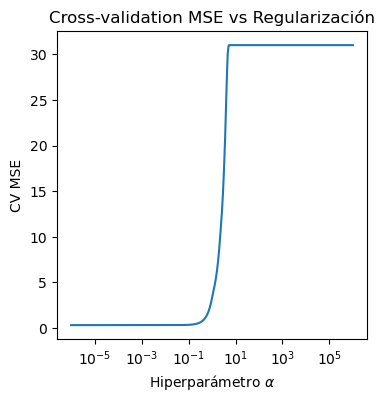

In [675]:
# Graficamos resultados
plt.figure(figsize=(4,4))
plt.plot(alphas, cv_mse)
plt.xscale('log')
plt.xlabel(r'Hiperparámetro $\alpha$')
plt.ylabel('CV MSE')
plt.title('Cross-validation MSE vs Regularización')
plt.show()

In [676]:
coef_list_lasso = []

# Lasso para varios alphas
for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_std, y)
    coef_list_lasso.append(lasso.coef_)

coefs_lasso = np.array(coef_list_lasso)

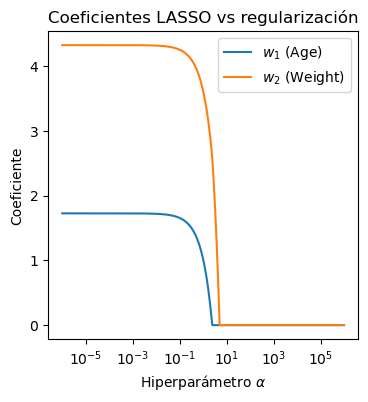

In [677]:
# Coeficientes vs alpha
plt.figure(figsize=(4,4))
plt.plot(alphas, coefs_lasso[:, 0], label=r'$w_1$ (Age)')
plt.plot(alphas, coefs_lasso[:, 1], label=r'$w_2$ (Weight)')
plt.xscale('log')
plt.xlabel(r'Hiperparámetro $\alpha$')
plt.ylabel('Coeficiente')
plt.legend()
plt.title('Coeficientes LASSO vs regularización')
plt.show()

In [678]:
# Mejor
best_alpha = lasso_cv.alpha_

# Coeficientes
best_coefs = lasso_cv.coef_

print(f"Mejor alpha: {best_alpha}")
print(f"Coeficientes: {best_coefs}")

Mejor alpha: 1e-06
Coeficientes: [1.72615893 4.32413491]


6.050293833934139


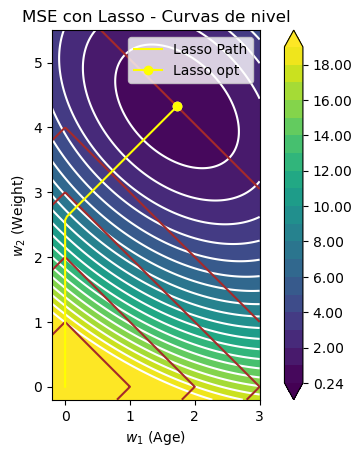

In [679]:
# Curvas de nivel - Geometría de Lasso

# Grilla
w_Age_std_vals = np.linspace(-0.2, 3, 200)
w_Weight_std_vals = np.linspace(-0.2, 5.5, 200)
W_Age_std, W_Weight_std = np.meshgrid(w_Age_std_vals, w_Weight_std_vals)

# MSE
MSE_std = np.zeros((W_Weight_std.shape[0],W_Age_std.shape[1]))
for i in range(W_Weight_std.shape[0]):
    for j in range(W_Age_std.shape[1]):
        w1, w2 = W_Age_std[i, j], W_Weight_std[i, j]
        w0 = y_mean
        y_pred = w0 + w1*X_std['Age'] + w2*X_std['Weight']
        mse_std = np.mean((y.values - y_pred) ** 2)
        MSE_std[i, j] = mse_std

w1 = best_coefs[0]
w2 = best_coefs[1]

# Óptimo con lasso
w0 = y_mean
y_pred = w0 + w1*X_std['Age'] + w2*X_std['Weight']
mse_level = np.mean((y.values - y_pred) ** 2)
levels = [mse_level]
levels.extend(range(1,20))
lasso_levels = [best_alpha * r for r in range(1,5,1)]
lasso_levels.append(best_alpha*np.sum(np.abs(np.array([w1, w2]))))
print(np.sum(np.abs(np.array([w1, w2]))))

lasso_norm = np.zeros_like(MSE_std)
for i in range(W_Weight_std.shape[0]):
    for j in range(W_Age_std.shape[1]):
        w1, w2 = W_Weight_std[i, j], W_Age_std[i, j]
        lasso_norm[i, j] = best_alpha*np.sum(np.abs(np.array([w1, w2])))

plt.figure()
cp = plt.contourf(W_Age_std, W_Weight_std, MSE_std, levels=levels, cmap='viridis', alpha=1, extend='both')

# Contornos
contour_line = plt.contour(W_Age_std, W_Weight_std, MSE_std, levels=levels, colors='white')

contour = plt.contour(W_Age_std, W_Weight_std, lasso_norm, levels=lasso_levels, colors='brown')

plt.colorbar(cp)
plt.plot(coefs_lasso[:, 0], coefs_lasso[:, 1], color='yellow', label='Lasso Path')

# Óptimo sin regularizar
plt.plot(model_std.coef_[0], model_std.coef_[1], color='white', marker='o')

# Óptimo ridge
plt.plot(best_coefs[0], best_coefs[1], color='yellow', marker='o', label='Lasso opt')

plt.xlabel(r'$w_1$ (Age)')
plt.ylabel(r'$w_2$ (Weight)')
plt.title('MSE con Lasso - Curvas de nivel')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.show()
